In [1]:
import pandas as pd
import re
from imblearn.under_sampling import RandomUnderSampler

In [4]:
df = pd.read_csv('processed_data.csv')
df.dropna(how='any', inplace=True)
df.head(5)

,label,subject,email_to,email_from,message
0,1,"Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca,"""Tomas Jacobs"" <RickyAmes@aol.com>",Content-Type: text/html;\nContent-Transfer-Enc...
1,0,Typo in /debian/README,debian-mirrors@lists.debian.org,Yan Morin <yan.morin@savoirfairelinux.com>,"Hi, i've just updated from the gulus and I che..."
2,1,authentic viagra,<the00@plg.uwaterloo.ca>,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...","Content-Type: text/plain;\n\tcharset=""iso-8859..."
3,1,Nice talking with ya,opt4@speedy.uwaterloo.ca,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>","Hey Billy, \n\nit was really fun going out the..."
4,1,or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca,"""Christi T. Jernigan"" <dcube@totalink.net>",Content-Type: multipart/alternative;\n ...


In [5]:
df['message'].loc[3]

"Hey Billy, \n\nit was really fun going out the other night \nand talking, while we were out you said that you felt\ninsecure about your manhood, I noticed in the toilets\nyou were quite small in that area : ) , but not to \nworry.. that website that I was telling you about is \nmy secret weapon to an extra 3 inches, trust me.. girls\nlove bigger ones, I've had 5 times as many chicks \nsince I used these pills a year ago. The package I used\nwas the 6 month supply one,  and its worth every \ncent and more.. the website is http://ctmay.com \nRing me on the weekend and we will go out and drink \nagain and let you know some more secrets : ).\nLater dude, Brad"

In [6]:
X, y = pd.DataFrame(df['message']), pd.DataFrame(df['label'])

In [7]:
undersaple = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = undersaple.fit_resample(X, y)

y_balanced.value_counts()

label
0        25192
1        25192
Name: count, dtype: int64

In [8]:
def clean_email(email):
    expressions = re.sub(r'Content-Type: \S+|Content-Transfer-Encoding: \S+|charset=\S+|tcharset=\S+|On\s.*?wrote:|0x[0-9]+|boundary=\S+|\S+NextPart\S+', '', email, flags=re.IGNORECASE)
    links_emails = re.sub(r'\S+@\S+|https?://\S+|www\.\S+', '', expressions, flags=re.IGNORECASE)
    other_characters = re.sub(r'[^a-zA-Z_ ]|_+', " ", links_emails, flags=re.IGNORECASE)
    multi_spaces = re.sub(r' {2,}'," ", other_characters)
    return multi_spaces

In [9]:
from tqdm.auto import tqdm
tqdm.pandas(desc = 'progress_bar')
X_balanced = pd.DataFrame(X_balanced)
X_balanced = X_balanced['message'].progress_apply(clean_email)

/home/michal/Software/Python/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
progress_bar: 100%|██████████| 50384/50384 [01:22<00:00, 607.82it/s] 


In [11]:
import torch
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/michal/Software/Python/ai/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


cuda


In [12]:
def tokenize_message(cleaned_message):
    return tokenizer(cleaned_message, return_tensors='pt', padding=True, truncation=True, max_length=512)

X_tokens = []
for message in tqdm(X_balanced, desc='progress'):
    X_tokens.append(tokenize_message(message))

progress:   0%|          | 0/50384 [00:00<?, ?it/s]

progress: 100%|██████████| 50384/50384 [05:56<00:00, 141.18it/s]


In [13]:
def get_bert_embeddings(token):
    with torch.no_grad():
        embedding = model(token['input_ids'], attention_mask=token['attention_mask'])
        return embedding.pooler_output

In [14]:
model.to(device)

X_embeddings = []
for token in tqdm(X_tokens, desc='progress'):
    token.to(device)
    X_embeddings.append(get_bert_embeddings(token))
    del token

progress: 100%|██████████| 50384/50384 [16:45<00:00, 50.10it/s]


In [15]:
X_embeddings_cpu = [embedding.detach().cpu() for embedding in X_embeddings]

del X_embeddings
torch.cuda.empty_cache()

In [16]:
X_embeddings_df = pd.DataFrame([embedding[0].tolist() for embedding in X_embeddings_cpu])
X_embeddings_df.index = X_balanced.index
X_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
1,-0.736354,-0.452856,-0.900266,0.607368,0.529109,-0.267249,0.433341,0.334154,-0.490229,-0.999952,...,0.505360,0.077232,0.879334,0.622733,-0.110042,0.129890,0.536032,-0.797027,-0.599843,0.759635
9,-0.744532,-0.458834,-0.744694,0.532082,0.311149,-0.129973,0.472880,0.302928,-0.515091,-0.999948,...,0.548646,0.256473,0.768397,0.710780,0.346100,0.227118,0.615897,-0.566250,-0.635862,0.742113
19,-0.703189,-0.482237,-0.837993,0.409060,0.359977,-0.125014,0.141702,0.312893,-0.582414,-0.999898,...,0.628102,0.357343,0.813748,0.582983,0.249469,-0.001337,0.718755,-0.735794,-0.579613,0.611510
20,-0.796584,-0.525187,-0.901323,0.721053,0.615162,-0.146203,0.736815,0.410643,-0.672798,-0.999979,...,0.644843,-0.195539,0.913168,0.737932,-0.083464,0.204052,0.676939,-0.717710,-0.695663,0.880075
28,-0.709045,-0.550619,-0.848801,0.587083,0.369468,-0.166272,0.443767,0.466522,-0.492667,-0.999962,...,0.607070,-0.386923,0.813543,0.633295,0.182254,0.055232,0.687205,-0.530300,-0.657097,0.604088


In [17]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

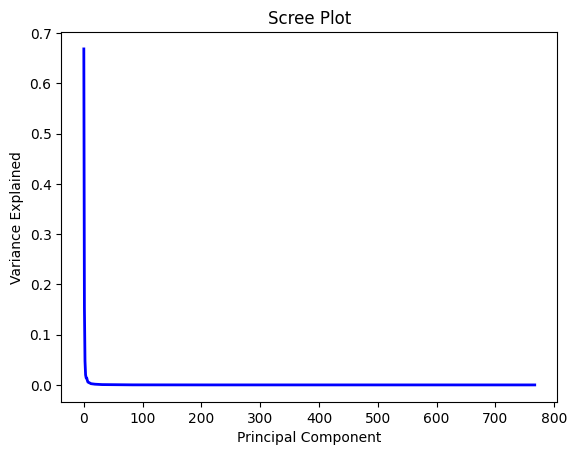

In [18]:
pca = PCA()
pca.fit(X_embeddings_df)

PC_values = np.arange(pca.n_components_)
plt.plot(PC_values, pca.explained_variance_ratio_, '-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [19]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(f'Percentage of variance explained by 13 principal components: {cumsum[12]*100}')

Percentage of variance explained by 13 principal components: 95.0247720174214


In [20]:
cumsum[3]

0.8892837806652201

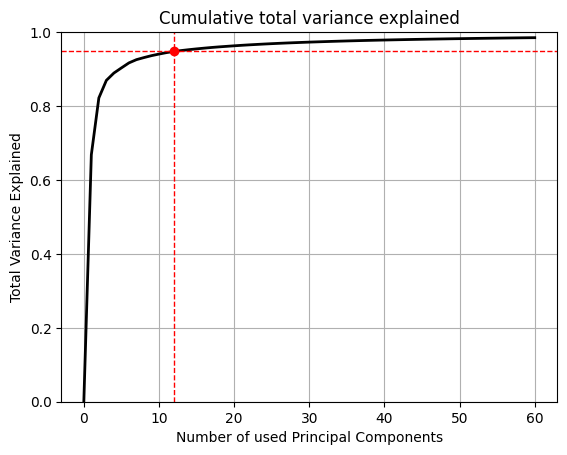

In [22]:
values = np.arange(0, 61)
plt.plot(values, np.concatenate([np.array([0]), cumsum[:60]]),linewidth=2, color='black')
plt.plot(12, cumsum[12], 'ro')
plt.axhline(y=cumsum[12], color='r', linestyle='--', lw=1)
plt.axvline(x=12, color='r', linestyle='--', lw=1)
plt.ylabel('Total Variance Explained')
plt.xlabel('Number of used Principal Components')
plt.ylim((0,1))
plt.grid()
plt.title('Cumulative total variance explained')
plt.show()

In [23]:
pca_13 = PCA(n_components=13)
pca_13.fit(X_embeddings_df)
pca_embeddings = pca_13.transform(X_embeddings_df)

In [24]:
X_pca = pd.DataFrame(pca_embeddings)
X_pca.index = X_balanced.index
X_pca.columns = [f'pca_{i}' for i in range(0, 12 + 1)]
X_pca.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12
1,2.352301,-0.776127,-1.018263,0.179621,0.428476,1.145457,-0.109729,0.127196,0.011035,0.302898,-0.040095,-0.351948,0.060799
9,3.939804,-1.509058,-0.692462,0.079318,1.103494,0.212633,0.030289,0.406922,0.040976,-0.172508,-0.035582,-0.145443,0.496701
19,2.987183,0.831495,-0.184284,0.258609,1.084511,0.095935,0.122495,0.486012,0.232857,-0.324556,0.399958,0.356646,0.754998
20,0.916919,-2.239033,-1.616736,0.710553,0.317823,-0.008515,-0.143397,0.145251,0.354858,-0.146318,-0.248080,0.044747,0.144934
28,3.182816,-0.673347,-0.002529,0.415266,0.571101,-0.158885,-1.009567,-0.024629,-0.440965,-0.018138,0.005876,-0.633176,0.039534


In [25]:
if (X_pca.index == y_balanced.index).all(): print('Indexes are the same')
processed_df = pd.concat(objs=[y_balanced, X_pca], axis=1)
processed_df = processed_df.sample(frac=1)
processed_df.head()

Indexes are the same


,label,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12
5049,0,-1.942495,4.503775,0.989897,-0.136373,0.031306,-0.979002,-0.208251,0.223024,0.105519,0.215910,0.521777,-0.059431,0.110921
47328,0,1.010724,-0.630826,-0.414920,0.203684,0.004939,0.232490,-0.914872,0.092836,-0.122631,0.287567,-0.110372,-0.062281,-0.132341
30303,1,-9.792177,-3.238162,0.511290,0.198238,-0.403885,0.407351,0.080823,-0.793677,0.695209,-0.668888,0.049802,-0.118460,0.103633
19219,1,-9.649083,-2.358724,0.425761,-0.512714,0.012001,0.130924,0.225414,-0.104580,0.131542,-0.419563,0.294364,-0.009525,0.112954
35947,1,-9.675876,-1.735106,0.927085,0.065313,-0.204944,0.043645,0.271444,-0.178751,-0.175065,-0.194047,-0.083362,-0.308353,-0.037760


In [26]:
processed_df.to_parquet('./processed_data.parquet')